# Tutorial: Find Dominant Colors in an Image through Clustering

Analyzing images with code can be difficult. How do you make your code "understand" the context of an image?

In general, the first step of analyzing images with AI is finding the dominant colors. In this tutorial, we're going to find dominant colors in images using matplotlib's imageclass. Finding dominant colors is also something you can do with third-party APIs, but we're going to build our own system for doing this so that we have total control over the process.

We will first look at converting an image into its component colors in the form of a matrix, and then perform k-means clustering on it to find the dominant colors.

Further, we analyze JPG images in this tutorial, the support for which is available only when you install an additional package, pillow.

In [2]:
import matplotlib
matplotlib.__version__

'3.1.0'

In [3]:
import PIL
PIL.__version__

'6.1.0'

In [4]:
import scipy
scipy.__version__

'1.3.0'

To read an image in Python, you need to import the image class of matplotlib. The imread() method of the image class decodes an image into its RGB values. The output of the imread() method is an array with the dimensions M x N x 3, where M and N are the dimensions of the image.

In [5]:
from matplotlib import image as img
Im = img.imread('./sunflower.jpg')
Im.shape

(400, 600, 3)

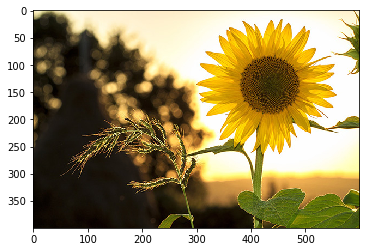

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(Im)
plt.show()

Before moving on to clustering the images, we need to perform an additional step. In the process of finding out the dominant colors of an image, we are not concerned about the position of the pixel. Hence, we need to convert the M x N x 3 matrix to three individual lists, which contain the respective red, blue and green values. The following snippet converts the matrix stored in image into three individual lists, each of length 240,000 (400 x 600).

In [8]:
r = []
g = []
b = []
for line in Im:
    for pixel in line:
        temp_r, temp_g, temp_b = pixel
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

The snippet above creates three empty lists, and then loops through each pixel of our image, appending the RGB values to our r, g, and b lists, respectively. If done correctly, each list wiill have a length of 240,000 (400 x 600).

Before we perform k-means clustering on the pixel data points, it might be good for us to figure out how many clusters are ideal for a given image, since not all images will have the same number of dominant colors.

Since we are dealing with three variables for clustering — the Red, Blue and Green values of pixels — we can visualize these variables on three dimensions to understand how many dominant colors may exist.

To make a 3D plot in matplotlib, we will use the Axes3D() class (documentation). After initializing the axes using the Axes3D() class, we use the scatter method and use the three lists of color values as arguments.

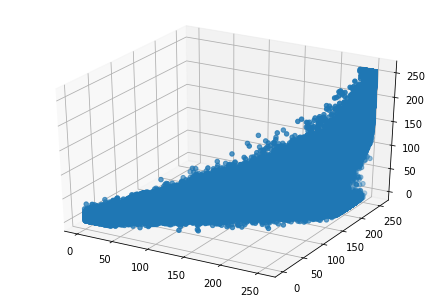

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

In [11]:
import pandas as pd
df = pd.DataFrame({'red': r,
'blue': b,
'green': g})

There are essentially three steps involved in the process of k-means clustering with SciPy:

1)  Standardize the variables by dividing each data point by its standard deviation. We will use the whiten() method of the vq class.
2)  Generate cluster centers using the kmeans() method.
3)  Generate cluster labels for each data point using the vq() method of the vqclass.

The first step above ensures that the variations in each variable affects the clusters equally. Imagine two variables with largely different scales. If we ignore the first step above, the variable with the larger scale and variation would have a larger impact on the formation of clusters, thus making the process biased. We therefore standardize the variable using the whiten() function. The whiten() function takes one argument, a list or array of the values of a variable, and returns the standardized values. After standardization, we print a sample of the data frame. Notice that the variations in the columns has reduced considerably in the standardized columns.

In [12]:
from scipy.cluster.vq import whiten
df['scaled_red'] = whiten(df['red'])
df['scaled_blue'] = whiten(df['blue'])
df['scaled_green'] = whiten(df['green'])
df.sample(n = 10)

,red,blue,green,scaled_red,scaled_blue,scaled_green
134007,56,24,50,0.580554,0.255177,0.542534
125051,225,74,166,2.332582,0.786796,1.801213
145980,108,52,83,1.119639,0.552884,0.900607
103547,203,0,147,2.104507,0.000000,1.595050
102840,50,25,33,0.518351,0.265809,0.358073
66755,46,22,37,0.476883,0.233912,0.401475
102452,55,2,35,0.570187,0.021265,0.379774
60634,59,25,47,0.611655,0.265809,0.509982
51655,40,20,34,0.414681,0.212648,0.368923
93816,30,8,20,0.311011,0.085059,0.217014


The next step is to perform k-means clustering with the standardized columns. We will use the kmeans() function of perform clustering. The kmeans() function (documentation) has two required arguments — the observations and the number of clusters. It returns two values — the cluster centers and the distortion. Distortion is the sum of squared distances between each point and its nearest cluster center. We will not be using distortion in this tutorial.

In [14]:
from scipy.cluster.vq import kmeans
cluster_centers, distortion = kmeans(df[['scaled_red', 'scaled_green', 'scaled_blue']], 2)

The final step in k-means clustering is generating cluster labels. However, in this exercise, we won't need to do that. We are only looking for the dominant colors, which are represented by the cluster centers.

We have performed k-means clustering and generated our cluster centers, so let's see what values they contain.

In [15]:
print(cluster_centers)

[[0.99401793 0.80810601 0.20205558]
 [2.60191383 2.60512207 2.13314706]]


As you can see, the results we get are standardized versions of RGB values. To get the original color values we need to multiply them with their standard deviations.

We will display the colors in the form of a palette using the imshow() method of matplotlib's pyplot class. However, to display colors, imshow() needs the values of RGB in the range of 0 to 1, where 1 signifies 255 in our original scale of RGB values. We therefore must divide each RGB component of our cluster centers with 255 in order to get to a value between 0 to 1, and display them through the imshow() method.

Finally, we have one more consideration before we plot the colors using the imshow()function (documentation). The dimensions of the cluster centers are N x 3, where N is the number of clusters. imshow() is originally intended to display an A X B matrix of colors, so it expects a 3D array of dimentions A x B x 3 (three color elements for each block in the palette). Hence, we need to convert our N x 3 matrix to 1 x N x 3 matrix by passing the colors of the cluster centers as a list with a single element. For instance, if we stored our colors in colors we need to pass [colors] as an argument to imshow().

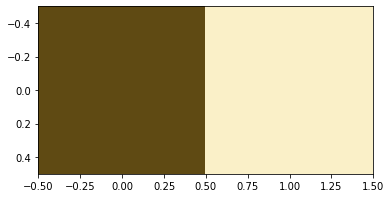

In [17]:
colors = []
r_std, g_std, b_std = df[['red', 'green', 'blue']].std()
for cluster_center in cluster_centers:
     scaled_r, scaled_g, scaled_b = cluster_center
     colors.append((
     scaled_r * r_std / 255,
     scaled_g * g_std / 255,
     scaled_b * b_std / 255
      ))
plt.imshow([colors])
plt.show()

In this post, we looked at a step by step implementation for finding the dominant colors of an image in Python using matplotlib and scipy. We started with a JPG image and converted it to its RGB values using the imread() method of the image class in matplotlib. We then performed k-means clustering with scipy to find the dominant colors. Finally, we displayed the dominant colors using the imshow()method of the pyplot class in matplotlib.